In [5]:
!python3 -m pip install --user numpy torchvision

Keyring is skipped due to an exception: org.freedesktop.DBus.Error.FileNotFound: Failed to connect to socket /run/user/1000/bus: No such file or directory
     |################################| 4.0MB 4.2MB/s eta 0:00:01
     |################################| 753.4MB 9.7kB/s eta 0:00:013     |#############################   | 682.8MB 3.2MB/s eta 0:00:22     |##############################  | 710.9MB 3.9MB/s eta 0:00:12
  Found existing installation: torch 1.3.0
    Uninstalling torch-1.3.0:
      Successfully uninstalled torch-1.3.0
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [167]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
# from torchvision import datasets, transforms
# from torchvision.utils import save_image
import numpy as np
import ipysh
import Hunch_utils  as Htls
import Hunch_lsplot as Hplt
import Hunch_tSNEplot as Hsne

%aimport Dataset_QSH

In [110]:
device = torch.device("cpu")

In [139]:
class VAE(nn.Module):
    def __init__(self, feature_dim=30, latent_dim=6, size=1):
        super(VAE, self).__init__()
        self.feature_dim = feature_dim
        fcs = feature_dim*size
        self.fc1 = nn.Sequential( 
                nn.Linear(feature_dim, fcs),
                nn.Linear(fcs, fcs),
                nn.Linear(fcs, fcs),
                nn.Linear(fcs, fcs),
        )
        self.fc21 = nn.Linear(fcs, latent_dim)
        self.fc22 = nn.Linear(fcs, latent_dim)
        self.fc3 = nn.Sequential(
            nn.Linear(latent_dim, fcs),
            nn.Linear(fcs, fcs),
            nn.Linear(fcs, fcs),
            nn.Linear(fcs, fcs),
        )
        self.fc4 = nn.Linear(fcs, feature_dim)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1,  self.feature_dim))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

    

In [134]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.mse_loss(recon_x, x.view(-1, 30), reduction='sum')
    # KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE #+ KLD


In [177]:
m = VAE()
x = torch.tensor(torch.randn([100,30]))

# F.mse_loss(x,m(x)[0].view(-1,30))
m(x)[0]

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor([[0.4459, 0.5152, 0.4928,  ..., 0.5291, 0.5094, 0.5405],
        [0.4525, 0.5052, 0.4848,  ..., 0.5277, 0.5340, 0.5368],
        [0.4606, 0.5119, 0.4811,  ..., 0.5222, 0.5379, 0.5214],
        ...,
        [0.4570, 0.5071, 0.4757,  ..., 0.5159, 0.5454, 0.5184],
        [0.4478, 0.5038, 0.4962,  ..., 0.5113, 0.5350, 0.5384],
        [0.4644, 0.5297, 0.4742,  ..., 0.5180, 0.5317, 0.5222]],
       grad_fn=<SigmoidBackward>)

In [204]:
xy = torch.tensor(torch.randn([100,30]))
XY = m(xy)[0][0]

x,y = torch.split(XY, 15)



/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


In [238]:
qsh = Dataset_QSH.Dataset_QSH()
file = ipysh.abs_builddir+'/te_db_r15_clean_shuffle.npy'
qsh.load(file)

qsh.dim = 15
qsh.set_null(np.nan)
qsh.set_normal_positive()

params = {
            'batch_size': 100,
            'shuffle': True,
            'num_workers': 6,
            'shuffle': True,
         }

ds = qsh.get_torch_dataset()
ds,ts = torch.utils.data.random_split(ds, [len(ds)-6000, 6000])

ds = DataLoader(ds,**params)
ts = DataLoader(ts,**params)


In [178]:
optimizer = optim.Adam(m.parameters(), lr=1e-3)
def train(model, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(ds):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        print("step: [{}], loss={}".format(batch_idx, loss.item()), end = '  \r')

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(ds)), end='\t' )

def test(model, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(ts):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
#             if i == 0:
#                 n = min(data.size(0), 8)
#                 comparison = torch.cat([data[:n],
#                                       recon_batch.view(args.batch_size, 1, 28, 28)[:n]])
#                 save_image(comparison.cpu(),
#                          'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(ts)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [179]:
for e in range(50):
    train(m,e)
    test(m,e)

====> Epoch: 0 Average loss: 18.2919	  ====> Test set loss: 0.4336
====> Epoch: 1 Average loss: 0.8408	6  ====> Test set loss: 0.4158
====> Epoch: 2 Average loss: 0.8232	8  ====> Test set loss: 0.4250
====> Epoch: 3 Average loss: 0.8134	  ====> Test set loss: 0.4096
====> Epoch: 4 Average loss: 0.8044	3  ====> Test set loss: 0.3959
====> Epoch: 5 Average loss: 0.7376	2  ====> Test set loss: 0.2692
====> Epoch: 6 Average loss: 0.5248	   ====> Test set loss: 0.2419
====> Epoch: 7 Average loss: 0.4989	   ====> Test set loss: 0.2183
====> Epoch: 8 Average loss: 0.4880	5  ====> Test set loss: 0.2371
====> Epoch: 9 Average loss: 0.4827	6  ====> Test set loss: 0.2226
====> Epoch: 10 Average loss: 0.4794	  ====> Test set loss: 0.2250
====> Epoch: 11 Average loss: 0.4799	  ====> Test set loss: 0.2011
====> Epoch: 12 Average loss: 0.4773	  ====> Test set loss: 0.2219
====> Epoch: 13 Average loss: 0.4755	  ====> Test set loss: 0.2167
====> Epoch: 14 Average loss: 0.4739	  ====> Test set loss: 0.2

In [180]:
for e in range(50):
    train(m,e)
    test(m,e)

====> Epoch: 0 Average loss: 0.1443	23  ====> Test set loss: 0.0680
====> Epoch: 1 Average loss: 0.1445	   ====> Test set loss: 0.0621
====> Epoch: 2 Average loss: 0.1442	2  ====> Test set loss: 0.0654
====> Epoch: 3 Average loss: 0.1435	83  ====> Test set loss: 0.0638
====> Epoch: 4 Average loss: 0.1439	7  ====> Test set loss: 0.0650
====> Epoch: 5 Average loss: 0.1430	1  ====> Test set loss: 0.0608
====> Epoch: 6 Average loss: 0.1429	64  ====> Test set loss: 0.0677
====> Epoch: 7 Average loss: 0.1428	67  ====> Test set loss: 0.0588
====> Epoch: 8 Average loss: 0.1427	1  ====> Test set loss: 0.0639
====> Epoch: 9 Average loss: 0.1423	55  ====> Test set loss: 0.0692
====> Epoch: 10 Average loss: 0.1427	  ====> Test set loss: 0.0671
====> Epoch: 11 Average loss: 0.1419	  ====> Test set loss: 0.0614
====> Epoch: 12 Average loss: 0.1424	  ====> Test set loss: 0.0593
====> Epoch: 13 Average loss: 0.1419	  ====> Test set loss: 0.0612
====> Epoch: 14 Average loss: 0.1417	  ====> Test set los

In [228]:
ts_batch = [x for x in ts][0][0]
pos = 0

In [266]:
m(ts_batch[0])[0]

AttributeError: 'tuple' object has no attribute 'detach'

66


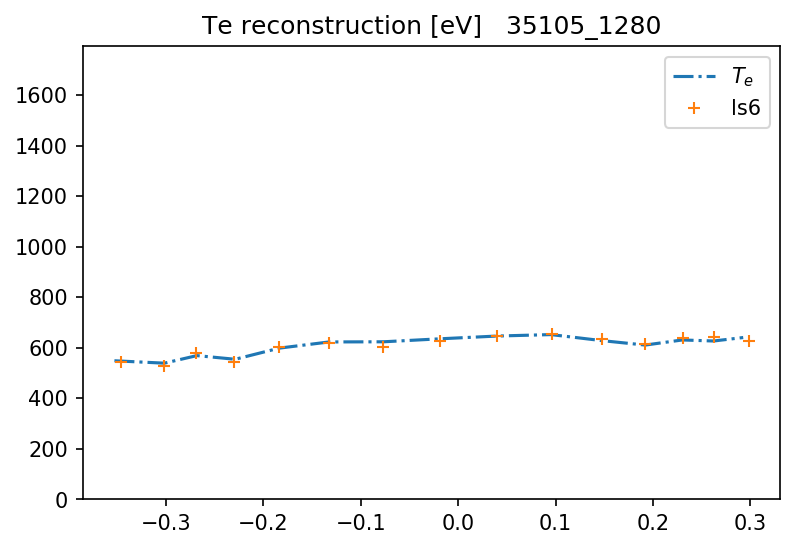

In [337]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors 
# %matplotlib notebook


print(pos)

def un(x, min=0., max=2242.511):
    return min + x*(max-min)

def unx(x, min=-0.373, max=0.353):
    return min + x*(max-min)

def plot_torch(xy, name=None, h='.'):
    fig = plt.figure('plot')    
    fig.set_dpi(150)
    ax = plt.gca()    
    ax.set_ylim(0.,un(0.8))
    x,y = torch.split(xy, 15, dim=0)
    plt.plot(unx(x),un(y),h, label=name)
    ax.legend()

    
def plot_te(vae, xy):    
    fig = plt.figure('plot')
    plt.clf()
    ax = plt.gca()
    ax.set_title( 'Te reconstruction [eV]   '+qsh[pos].label.decode("utf-8") )
    vae.eval()    
    XY = vae(xy)[0][0].detach()

    plot_torch(xy, '$T_e$','-.')
    plot_torch(XY, 'ls6','+')


plot_te(m, ts_batch[pos])
pos += 1



array([0.02898344, 0.09607311, 0.14265138, 0.19771932, 0.26045254,
       0.33110553, 0.4067115 , 0.48839146, 0.5687736 , 0.6456776 ,
       0.71633047, 0.7790637 , 0.83331555, 0.8793663 , 0.91799575,
              nan,        nan,        nan,        nan,        nan],
      dtype=float32)